In [29]:
import pandas as pd
! pip install ace_tools_open
import ace_tools_open as tools

# Load the datasets to understand their structure and contents
campaign_descriptions = pd.read_csv('campaign_descriptions.csv')
coupons = pd.read_csv('coupons.csv')
demographics = pd.read_csv('demographics.csv')
transactions = pd.read_csv('transactions.csv')
campaigns = pd.read_csv('campaigns.csv')
coupon_redemptions = pd.read_csv('coupon_redemptions.csv')
products = pd.read_csv('products.csv')
promotions = pd.read_csv('promotions.csv')

# Display the first few rows of each dataset to understand their structure
campaign_descriptions_head = campaign_descriptions.head()
coupons_head = coupons.head()
demographics_head = demographics.head()
transactions_head = transactions.head()

campaign_descriptions_head, coupons_head, demographics_head, transactions_head


   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.4 MB 1.7 MB/s eta 0:00:01
   ------------------------------- -------- 1.1/1.4 MB 13.9 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 12.8 MB/s eta 0:00:00


(   campaign_id campaign_type  start_date    end_date
 0            1        Type B  2017-03-03  2017-04-09
 1            2        Type B  2017-03-08  2017-04-09
 2            3        Type C  2017-03-13  2017-05-08
 3            4        Type B  2017-03-29  2017-04-30
 4            5        Type B  2017-04-03  2017-05-07,
     coupon_upc  product_id  campaign_id
 0  10000085207   9676830.0           26
 1  10000085207   9676943.0           26
 2  10000085207   9676944.0           26
 3  10000085207   9676947.0           26
 4  10000085207   9677008.0           26,
    household_id    age     income home_ownership marital_status  \
 0             1    65+     35-49K      Homeowner        Married   
 1          1001  45-54     50-74K      Homeowner      Unmarried   
 2          1003  35-44     25-34K            NaN      Unmarried   
 3          1004  25-34     15-24K            NaN      Unmarried   
 4           101  45-54  Under 15K      Homeowner        Married   
 
   household_size 

In [31]:
# Summary statistics for demographics and transactions

# Demographics Overview
demographics_summary = demographics.describe(include='all')

# Transactions Overview
transactions_summary = transactions.describe(include='all')

# Display summaries to the user
tools.display_dataframe_to_user("Demographics Summary", demographics_summary)
tools.display_dataframe_to_user("Transactions Summary", transactions_summary)


Demographics Summary


Transactions Summary


In [33]:
# Summary statistics for demographics and transactions

# Demographics Overview
demographics_summary = demographics.describe(include='all')

# Transactions Overview
transactions_summary = transactions.describe(include='all')

# Display summaries to the user
tools.display_dataframe_to_user("Demographics Summary", demographics_summary)
tools.display_dataframe_to_user("Transactions Summary", transactions_summary)


Demographics Summary


Transactions Summary


In [43]:
# Aggregating transaction and demographic data to create customer-level features

# Merging transactions and demographics on customer identifier
# Calculating customer-level features from transactions

# Aggregating transactions to calculate average spend, total spend, and purchase frequency per customer
customer_transactions = transactions.groupby('household_id').agg({
    'quantity': 'sum',
    'sales_value': ['sum', 'mean'],  # Total and average sales value per customer
    'product_id': 'count'             # Purchase frequency
}).reset_index()

# Renaming columns for easier reference
customer_transactions.columns = ['household_id', 'total_quantity', 'total_spend', 'avg_spend', 'purchase_frequency']
# Merging with demographic data to create a comprehensive customer profile
customer_profile = pd.merge(customer_transactions, demographics, on='household_id', how='left')

# Display the customer profile to understand the aggregated features
tools.display_dataframe_to_user("Customer Profile Overview", customer_profile.head())


Customer Profile Overview


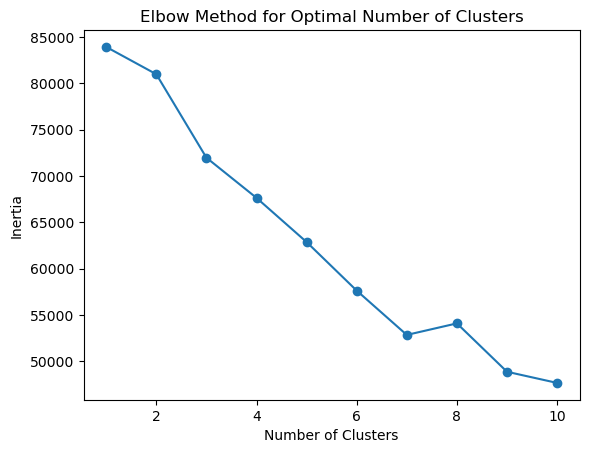

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# Converting non-numerical data to categorical data using one-hot encoding
customer_profile_encoded = pd.get_dummies(customer_profile, columns=customer_profile.select_dtypes(include=['object']).columns, drop_first=True)

# Dropping customer_id for clustering and filling missing values with median values
customer_profile_features = customer_profile_encoded.drop(columns=['household_id']).fillna(customer_profile_encoded.median())

# Standardizing the data to prepare for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profile_features)

# Using the Elbow Method to determine the optimal number of clusters
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow graph to identify the optimal number of clusters
import matplotlib.pyplot as plt

plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


In [63]:
# Proceeding with K-Means clustering using 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
customer_profile['cluster'] = kmeans.fit_predict(scaled_features)

# Selecting only numeric columns for aggregation
numeric_columns = customer_profile.select_dtypes(include=[np.number]).columns

# Aggregating using only the numeric columns to avoid TypeError
cluster_summary = customer_profile.groupby('cluster')[numeric_columns].agg(['mean', 'std']).reset_index()

# Displaying the cluster summary to provide insights on customer behavior
tools.display_dataframe_to_user("Customer Cluster Summary", cluster_summary)

Customer Cluster Summary


In [61]:
customer_profile_encoded.columns

Index(['household_id', 'total_quantity', 'total_spend', 'avg_spend',
       'purchase_frequency', 'age_25-34', 'age_35-44', 'age_45-54',
       'age_55-64', 'age_65+', 'income_125-149K', 'income_15-24K',
       'income_150-174K', 'income_175-199K', 'income_200-249K',
       'income_25-34K', 'income_250K+', 'income_35-49K', 'income_50-74K',
       'income_75-99K', 'income_Under 15K',
       'home_ownership_Probable Homeowner', 'home_ownership_Probable Renter',
       'home_ownership_Renter', 'marital_status_Unmarried', 'household_size_2',
       'household_size_3', 'household_size_4', 'household_size_5+',
       'household_comp_1 Adult No Kids', 'household_comp_2 Adults Kids',
       'household_comp_2 Adults No Kids', 'kids_count_1', 'kids_count_2',
       'kids_count_3+'],
      dtype='object')